# TP : Auto-encodeurs variationnels

Dans ce TP, dans un premier temps, nous allons entraîner un modèle génératif de type d'auto-encodeur variationnel sur le jeu de données MNIST (chiffres manuscrits de 0 à 9). Dans un deuxième, temps nous allons essayer de générer des chiffres en échantiollannant dans l'espace latent.

In [109]:
import torch
from torch import nn
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Définir l'architecture du VAE
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, 50)  # Moyenne mu
        self.fc22 = nn.Linear(400, 50)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(50, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Paramètres
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vae = VAE().to(device)
optimizer = torch.optim.Adam(vae.parameters(), lr=1e-3)

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Entraînement du modèle
for epoch in range(10):
    vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 0, Loss: 169.98929365234375
Epoch 1, Loss: 127.15810691731771
Epoch 2, Loss: 117.2300044921875
Epoch 3, Loss: 112.82003365885417
Epoch 4, Loss: 110.44227161458333
Epoch 5, Loss: 109.04707755533855
Epoch 6, Loss: 107.93155133463542
Epoch 7, Loss: 107.24964326171875
Epoch 8, Loss: 106.5965842610677
Epoch 9, Loss: 106.23125408528645


## Exercices

* Rédiger un code Python qui permet d'échantillonner à partir de l'espace latent pour générer de nouvelles images.

Pour faire de l'inférence, nous n'avons pas besoin de faire passer le gradient à travers le processus d'échantillonnage, car nous ne faisons pas de rétropropagation.

On suppose que le modèle a été correctement entraîné et que l'espace latent suit la distribution Gaussienne. 

Donc, directement échantillonner de cette distribution sans avoir besoin de la reparamétrisation.

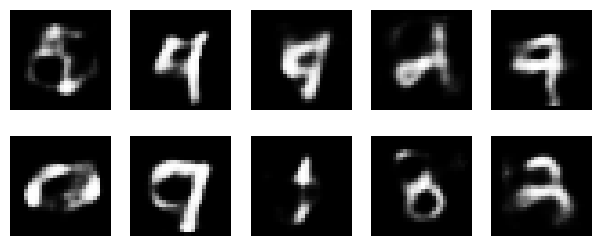

In [110]:
def generate_images(vae, num_samples=10, latent_dim=50, image_size=(28, 28), images_per_row=5):
    vae.eval()

    z = torch.randn(num_samples, latent_dim).to(device)

    with torch.no_grad():
        generated_images = vae.decode(z)

    generated_images = generated_images.view(-1, *image_size)

    num_rows = num_samples // images_per_row + (0 if num_samples % images_per_row == 0 else 1)

    fig, axes = plt.subplots(num_rows, images_per_row, figsize=(images_per_row * 1.5, num_rows * 1.5))
    axes = axes.flatten()

    for i, ax in enumerate(axes):
        if i < num_samples:
            ax.imshow(generated_images[i].cpu().numpy(), cmap='gray')
            ax.axis('off')
        else:
            ax.axis('off')

    plt.show()

generate_images(vae)

### Changer la dimension de l'espace latent.


In [111]:
#  CustomVAE avec une dimension latente à 2
class CustomVAE(nn.Module):
    def __init__(self, latent_dim=2):  # Nouvelle dimension latente
        super(CustomVAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, latent_dim)  # Moyenne mu
        self.fc22 = nn.Linear(400, latent_dim)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = torch.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = torch.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Fonction pour afficher des images générées
def show_generated_images(vae, num_samples=10, latent_dim=100, image_size=(28, 28)):
    vae.eval()
    z = torch.randn(num_samples, latent_dim)
    with torch.no_grad():
        generated_images = vae.decode(z).view(-1, *image_size)
    
    fig, axes = plt.subplots(1, num_samples, figsize=(num_samples * 1.5, 2))
    for i, ax in enumerate(axes):
        ax.imshow(generated_images[i].cpu().numpy(), cmap='gray')
        ax.axis('off')
    plt.show()

# Création d'une instance du modèle CustomVAE avec la nouvelle dimension latente
custom_vae = CustomVAE(latent_dim=2)

# entraînement du modèle
optimizer = torch.optim.Adam(custom_vae.parameters(), lr=1e-3)
for epoch in range(10):
    custom_vae.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = custom_vae(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')


Epoch 0, Loss: 190.26195426432292
Epoch 1, Loss: 167.57365087890625
Epoch 2, Loss: 164.00678255208334
Epoch 3, Loss: 161.9788375
Epoch 4, Loss: 160.45445859375
Epoch 5, Loss: 159.17348347981772
Epoch 6, Loss: 158.04359568684896
Epoch 7, Loss: 156.9704220703125
Epoch 8, Loss: 156.10488528645834
Epoch 9, Loss: 155.32836665039062


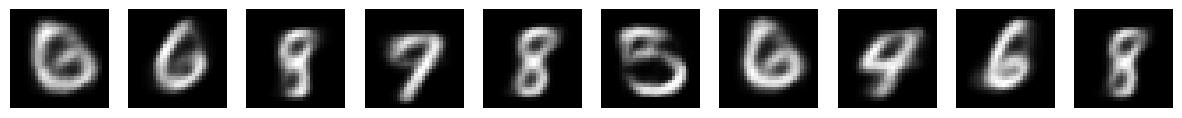

In [112]:
# Affichage des images générées
show_generated_images(custom_vae, latent_dim=2)

En effet, on remarque qu'avec une dimension de 2, nous obtenons de meilleurs résultats.  On peut penser qu'au vu du peu de complexité dans nos données, un espace latent de petite dimension peut suffire à capturer l'essentiel des variations des données. 

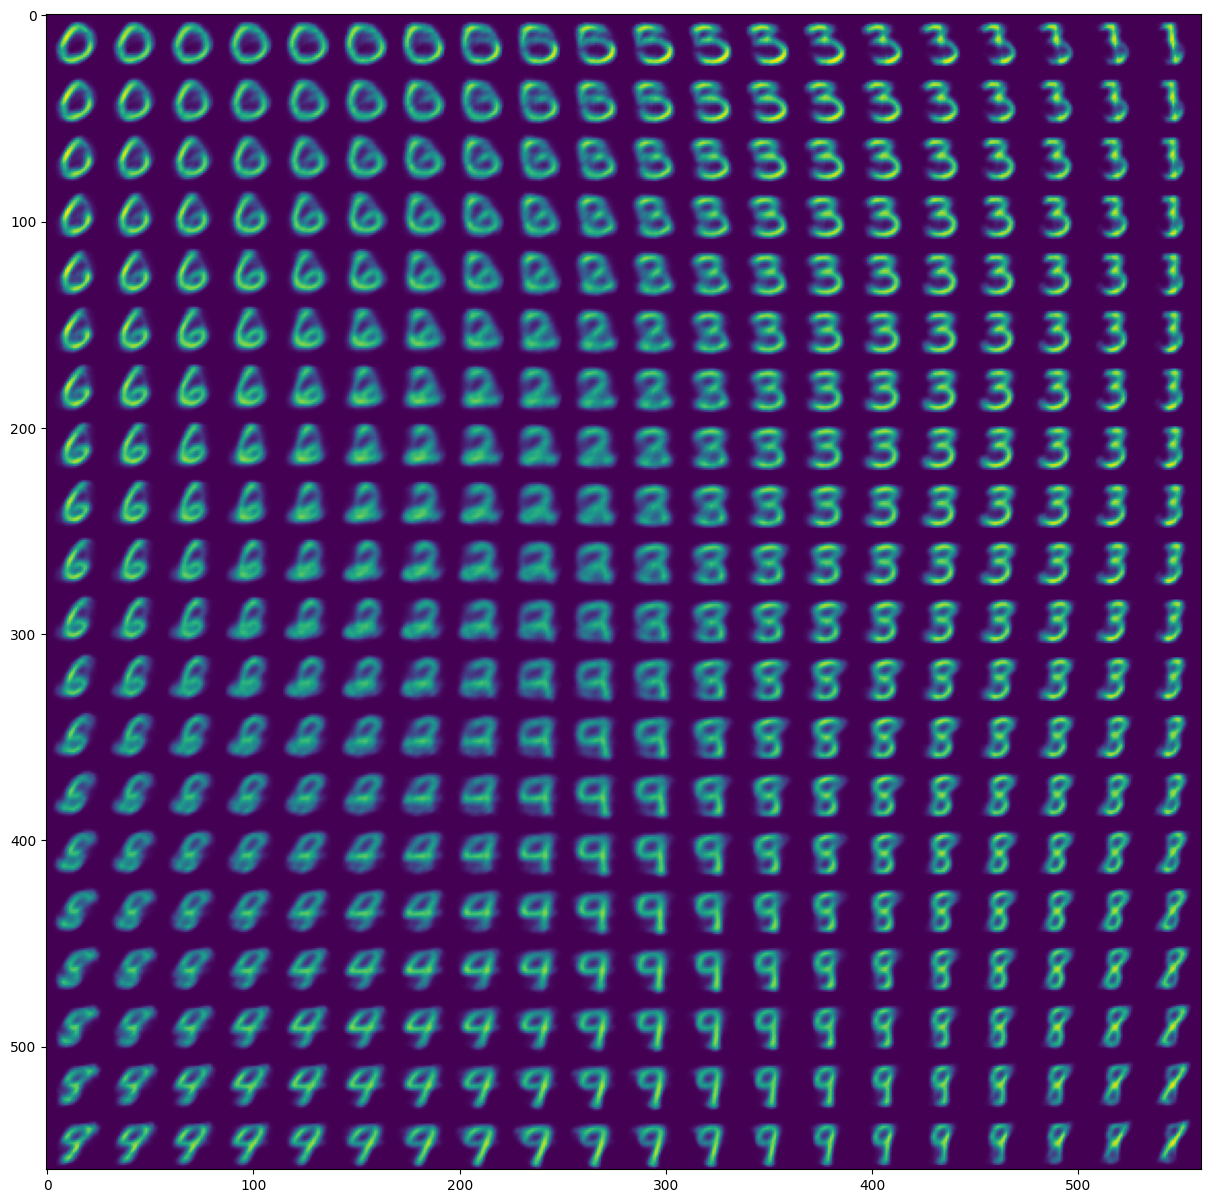

In [113]:
import numpy as np
from scipy.stats import norm
n = 20 
digit_size = 28

u_grid = np.dstack(np.meshgrid(np.linspace(0.05, 0.95, n), np.linspace(0.05, 0.95, n)))
z_grid = norm.ppf(u_grid)
z_grid = torch.tensor(z_grid, dtype=torch.float32).view(-1, 2).to(device)
x_decoded = custom_vae.decode(z_grid).cpu().detach().numpy()

import matplotlib.pyplot as plt
from matplotlib import cm
figsize = 15
figure = np.zeros((digit_size * n, digit_size * n))
for i in range(n):
    for j in range(n):
        digit = x_decoded[i * n + j].reshape(digit_size, digit_size)
        figure[i * digit_size: (i + 1) * digit_size,
        j * digit_size: (j + 1) * digit_size] = digit
plt.figure(figsize=(figsize, figsize))
plt.imshow(figure)
plt.show()

##  Changer l'architecture du VAE.

In [122]:
import torch.nn.functional as F

class ImprovedCustomVAE(nn.Module):
    def __init__(self):
        super(ImprovedCustomVAE, self).__init__()

        # Encodeur
        self.fc1 = nn.Linear(28 * 28, 128)
        self.fc21 = nn.Linear(128, 64)
        self.fc22 = nn.Linear(64, 3)  # Moyenne mu
        self.fc23 = nn.Linear(64, 3)  # Log-variance

        # Décodeur
        self.fc3 = nn.Linear(3, 64)
        self.fc4 = nn.Linear(64, 128)
        self.fc5 = nn.Linear(128, 28 * 28)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        h2 = F.relu(self.fc21(h1))
        return self.fc22(h2), self.fc23(h2)  # Retourne mu et logvar
    
    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        h4 = F.relu(self.fc4(h3))
        return torch.sigmoid(self.fc5(h4))
    
    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 28*28))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Fonction de perte
def loss_function(recon_x, x, mu, logvar):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return BCE + KLD

# Création d'une instance du modèle CustomVAE avec la nouvelle dimension latente
improvedCustomVAE = ImprovedCustomVAE()

# entraînement du modèle
optimizer = torch.optim.Adam(improvedCustomVAE.parameters(), lr=1e-3)
for epoch in range(10):
    improvedCustomVAE.train()
    train_loss = 0
    for data, _ in train_loader:
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = improvedCustomVAE(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()

    print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Epoch 0, Loss: 201.03476310221353
Epoch 1, Loss: 159.54880400390624
Epoch 2, Loss: 153.43508720703124
Epoch 3, Loss: 149.54372294921876
Epoch 4, Loss: 146.72812807617188
Epoch 5, Loss: 144.7090023111979
Epoch 6, Loss: 143.07553603515626
Epoch 7, Loss: 141.83480442708333
Epoch 8, Loss: 140.79412819010417
Epoch 9, Loss: 139.83934459635418


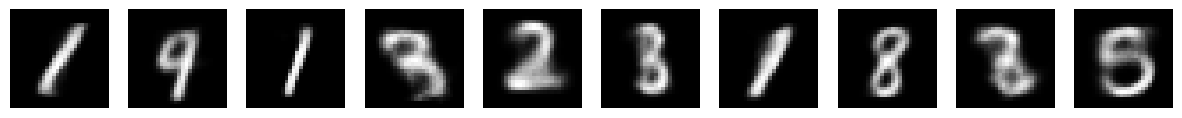

In [127]:
show_generated_images(improvedCustomVAE, latent_dim=3)

# Paramétrer la fonction loss pour pondérer les deux termes
Nous allons créer une fonction de loss qui puisse apprendre à paramétrer la pondération des deux termes.

In [143]:
# Ajout de pondérations à la fonction de perte pour BCE et KLD
def loss_function_weighted(recon_x, x, mu, logvar, bce_weight=1.0, kld_weight=1.0):
    BCE = nn.functional.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return bce_weight * BCE + kld_weight * KLD

Essayons de faire varier les poids en tant qu'hyperparamètres pour voir si nous pouvons obtenir de meilleurs résultats.

In [174]:
def train_vae(model, train_loader, bce_weight, kld_weight, epochs=10):
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    model.train()
    for epoch in range(epochs):
        train_loss = 0
        for data, _ in train_loader:
            data = data.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(data)
            loss = loss_function(recon_batch, data, mu, logvar, bce_weight, kld_weight)
            loss.backward()
            train_loss += loss.item()
            optimizer.step()
        print(f'Epoch {epoch}, Loss: {train_loss / len(train_loader.dataset)}')

Training with BCE Weight: 1.0, KLD Weight: 1.0
Epoch 0, Loss: 204.8520071940104
Epoch 1, Loss: 163.2081344889323
Epoch 2, Loss: 154.34669946289063
Epoch 3, Loss: 149.37899280598958
Epoch 4, Loss: 146.38000569661457
Epoch 5, Loss: 144.3514123046875
Epoch 6, Loss: 142.68398286132813
Epoch 7, Loss: 141.40841049804686
Epoch 8, Loss: 140.35036806640625
Epoch 9, Loss: 139.44687454427083


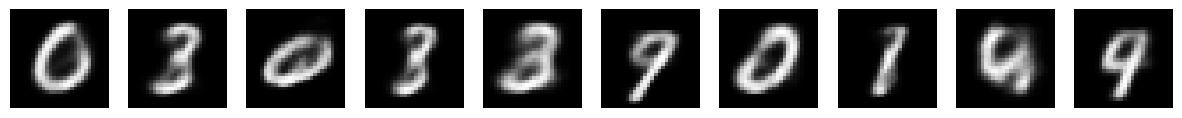

Training with BCE Weight: 0.5, KLD Weight: 1.0
Epoch 0, Loss: 104.18980685221354
Epoch 1, Loss: 84.61044656575521
Epoch 2, Loss: 79.9929274983724
Epoch 3, Loss: 78.1689017578125
Epoch 4, Loss: 76.86378032226563
Epoch 5, Loss: 75.90999576822917
Epoch 6, Loss: 75.16214952799479
Epoch 7, Loss: 74.58892463378906
Epoch 8, Loss: 74.0825478108724
Epoch 9, Loss: 73.62657492675781


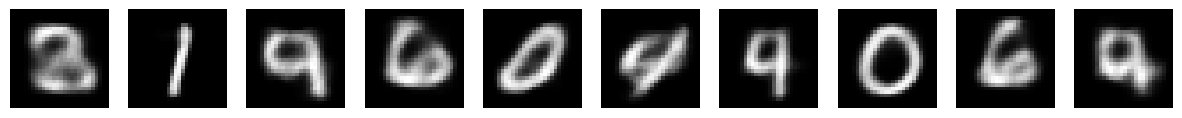

Training with BCE Weight: 1.0, KLD Weight: 0.5
Epoch 0, Loss: 195.53689920247396
Epoch 1, Loss: 157.02752057291667
Epoch 2, Loss: 149.52756069335936
Epoch 3, Loss: 144.79651404622396
Epoch 4, Loss: 142.0184013997396
Epoch 5, Loss: 139.92956181640625
Epoch 6, Loss: 138.17044599609375
Epoch 7, Loss: 136.804587109375
Epoch 8, Loss: 135.63086770833334
Epoch 9, Loss: 134.65658383789062


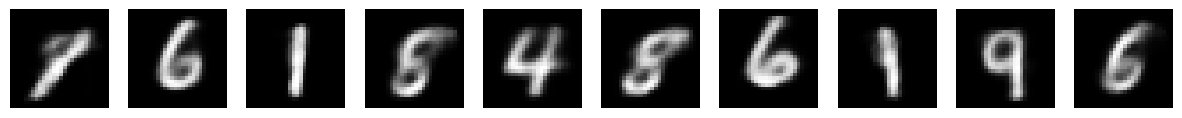

Training with BCE Weight: 0.5, KLD Weight: 0.5
Epoch 0, Loss: 100.3165221110026
Epoch 1, Loss: 79.59999973958334
Epoch 2, Loss: 76.32081974283854
Epoch 3, Loss: 74.50212701009114
Epoch 4, Loss: 73.21810042317708
Epoch 5, Loss: 72.17591805826822
Epoch 6, Loss: 71.34528822428385
Epoch 7, Loss: 70.68017543945312
Epoch 8, Loss: 70.09081321614583
Epoch 9, Loss: 69.6332357828776


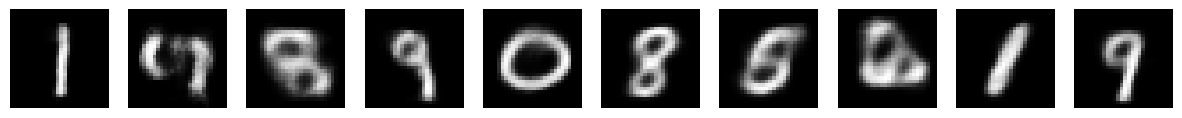

In [176]:
bce_kld_weights = [(1.0, 1.0), (0.5, 1.0), (1.0, 0.5), (0.5, 0.5)]

# Chargement des données MNIST
train_loader = DataLoader(
    datasets.MNIST('../data', train=True, download=True, transform=transforms.ToTensor()),
    batch_size=128, shuffle=True)

# Tester le modèle avec différents poids
for bce_weight, kld_weight in bce_kld_weights:
    print(f"Training with BCE Weight: {bce_weight}, KLD Weight: {kld_weight}")
    model = ImprovedCustomVAE().to(device)
    train_vae(model, train_loader, bce_weight, kld_weight)
    show_generated_images(model, latent_dim=3)

On obtient finalement des résultats similaires mais assez satisfaisants pour la génération de chiffres manuscrits.